**02452** *Machine Learning*, Technical University of Denmark

- This Jupyter notebook contains exercises where you fill in missing code related to the lecture topic. *First*, try solving each task yourself. *Then* use the provided solution (an HTML file you can open in any web browser) as inspiration if needed. If you get stuck, ask a TA for help.

- Some tasks may be difficult or time-consuming - using the solution file or TA support is expected and perfectly fine, as long as you stay active and reflect on the solution.

- You are not expected to finish everything during the session. Prepare by looking at the exercises *before* the class, consult the TAs *during* class, and complete the remaining parts *at home*.

---

# Week 8: Bias/Variance and Ensemble methods

**Content:**
- Part 1: Regularization for trading of variance with bias
- Part 2: Regression on the `body` dataset with regularizaton
- Part 3: Classifying the `wine` dataset with regularizaton
- Part 4: Ensemble methods

**Objectives:**
- Understand the bias/variance trade-off.
- Understand how introducing regularization in linear and logistic regression (regularized regression) can help us balance the bias/variance trade-off.
- Understand ensemble methods (bagging and boosting) and relate the methods to the bias/variance trade-off.

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler


# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

def setup_storage_for_experiment(K_outer, K_inner, num_hyperparams):
    # Setup storage for the optimal hyperparameters found from the inner CV
    optimal_hyperparameters = np.empty(K_outer)

    # Setup storage for model coefficients and errors for each experiment in all inner folds
    ws_inner = np.empty((M + 1, K_outer, K_inner, num_hyperparams))
    train_errors_inner = np.empty((K_outer, K_inner, num_hyperparams))
    test_errors_inner = np.empty((K_outer, K_inner, num_hyperparams))

    # Setup storage for model coefficients for each experiment in all outer folds
    ws_outer = {
        'not regularized': np.empty((M + 1, K_outer)),
        'regularized': np.empty((M + 1, K_outer))
    }
    # Setup storage for errors as a dictionary
    errors_outer = {
        'train': {
            'baseline (no features)': np.empty((K_outer, 1)), 
            'not regularized': np.empty((K_outer, 1)),
            'regularized': np.empty((K_outer, 1))
        },
        'test': {
            'baseline (no features)': np.empty((K_outer, 1)), 
            'not regularized': np.empty((K_outer, 1)),
            'regularized': np.empty((K_outer, 1))
        }
    }
    return optimal_hyperparameters, ws_inner, train_errors_inner, test_errors_inner, ws_outer, errors_outer

def print_regularization_results(errors):
    # Display results
    print("Linear regression without regularization:")
    print(f"- Training error: \t{errors['train']['not regularized'].mean():.4f}")
    print(f"- Test error: \t\t{errors['test']['not regularized'].mean():.4f}")
    print(f"- R^2 train: \t\t{(errors['train']['baseline (no features)'].sum() - errors['train']['not regularized'].sum()) / errors['train']['baseline (no features)'].sum():.4f}")
    print(f"- R^2 test: \t\t{(errors['test']['baseline (no features)'].sum() - errors['test']['not regularized'].sum()) / errors['test']['baseline (no features)'].sum():.4f}\n")

    print("Regularized linear regression:")
    print(f"- Training error: \t{errors['train']['regularized'].mean():.4f}")
    print(f"- Test error: \t\t{errors['test']['regularized'].mean():.4f}")
    print(f"- R^2 train: \t\t{(errors['train']['baseline (no features)'].sum() - errors['train']['regularized'].sum()) / errors['train']['baseline (no features)'].sum():.4f}")
    print(f"- R^2 test: \t\t{(errors['test']['baseline (no features)'].sum() - errors['test']['regularized'].sum()) / errors['test']['baseline (no features)'].sum():.4f}\n")

def get_grid_points(x_min, x_max, y_min, y_max, delta=5e-3):
    # Create a grid of points with the specified resolution
    xx = np.arange(x_min, x_max, delta)
    yy = np.arange(y_min, y_max, delta)
    # Make a mesh-grid that spans the grid-range defined
    grid = np.stack(np.meshgrid(xx, yy))
    return grid, xx, yy

def plot_decision_boundary(predict_function, X, threshold=None, ax=None, fig=None, cmap='RdBu_r'):
    # Set grid range based on the data
    grid_range = [X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()]  # [x_min, x_max, y_min, y_max]
    # Add 10% margin to the grid range to ensure points on the edge are included
    margin_x = 0.1 * (grid_range[1] - grid_range[0])
    margin_y = 0.1 * (grid_range[3] - grid_range[2])
    grid_range[0] -= margin_x
    grid_range[1] += margin_x
    grid_range[2] -= margin_y
    grid_range[3] += margin_y

    # Get grid points
    grid, xx, yy = get_grid_points(*grid_range, delta=5e-3)
    # Reshape grid to a list of points
    grid_points = np.reshape(grid, (2, -1)).T

    # Compute model predictions on the grid points (i.e. the probability of class 1)
    grid_predictions = predict_function(grid_points)

    # Reshape the predictions back to the grid shape
    decision_boundary = np.reshape(grid_predictions, (len(yy), len(xx)))

    # Plot the decision boundary
    img = ax.imshow(decision_boundary, extent=grid_range, origin='lower', cmap=cmap, alpha=0.5, vmin=0, vmax=1)
    fig.colorbar(img, ax=ax)
    if threshold is not None:
        ax.contour(grid[0], grid[1], decision_boundary, levels=[threshold], colors='k')
    ax.grid(False)
    ax.set_aspect('auto')

## Introduction

We previously studied how models can easily overfit the training data if the model is too flexible. We argued that we can mitigate overfitting, by using larger datasets or simplifying the model, e.g. by reducing the number of parameters in linear models. These strategies apply broadly across modeling techniques. However, collecting more data can be expensive and in some settings we might need a highly flexible model to be able to fit complex data. In this exercise, we will study other approaches to reducing overfitting - specifically, we will consider techniques that *trade off model variance with model bias*.

Bias and variance describe how well a model generalizes beyond its training data:
- **Bias** relates to *how well the model fits the training data*. The better it fits this data, the *lower* the bias is. A too simple model (*high bias*) might not fit the data which results in *underfitting*.
- **Variance** relates to the *flexibility of the model when we train it on a new data set*. If we train a model on new training sets, their outputs can be very different as the model's parameters have greater variance. This relates to *overfitting*.

The fact that we can not prevent under- and overfitting simultaneously is why we call it *the bias–variance trade-off*. Reducing variance usually increases bias, and reducing bias usually increases variance. Therefore we need to find a balance where the model captures real patterns without overfitting to noise in the data.

Alternatively, one can combine the predictions of multiple models in an *ensemble*. This can reduce model variance without greatly increasing bias which can give better generalization performance.


---
## Part 1: Regularization for trading of variance with bias

An approach to control for the complexity of the model is to regularize the parameters in the objective function. For instance for linear regression we can regularize the parameters $\boldsymbol{w}$ by the Frobenius norm, which essentially forces the model to be less flexible but with the benefit that it is also less likely to overfit. By regularizing the weights in this manner, the considered cost function is the mean squared error with an additional term, i.e.:
$$
\begin{align*}
    E\left(\boldsymbol{X}, \boldsymbol{y}, \boldsymbol{w}\right) &=\sum_n \|y_n -\boldsymbol{x}_n^{\top}\boldsymbol{w}\|_F^2+\lambda \|\boldsymbol{w}\|_F^2 =\sum_n (y_n -\boldsymbol{x}_n^{\top}\boldsymbol{w})^2+\lambda \underset{=\lVert \boldsymbol{w}\rVert_2^2}{\underbrace{\boldsymbol{w}^{\top}\boldsymbol{w}}}
\end{align*}
$$
where $\left(\boldsymbol{X}, \boldsymbol{y}\right)$ is the data matrix and target vector. Solving the equation $\frac{\partial E}{\partial \boldsymbol{w}}=0$ we obtain $\boldsymbol{w}=(\boldsymbol{X}^\top\boldsymbol{X}+\lambda\boldsymbol{I})^{-1}\boldsymbol{X}^\top\boldsymbol{y}$ (see also the lecture slides for today). This type of regularization is commonly known as *ridge regularization* 

When regularizing a model as above we apply the same regularization strength to all features, and so it is important to standardize the features. Note that if we include a bias term (offset/intercept) we do not regularize it. In the following, we will see how regularization can help us to avoid overfitting by trading off model variance with bias. For doing so, we revisit the polynomial dataset from week 6.

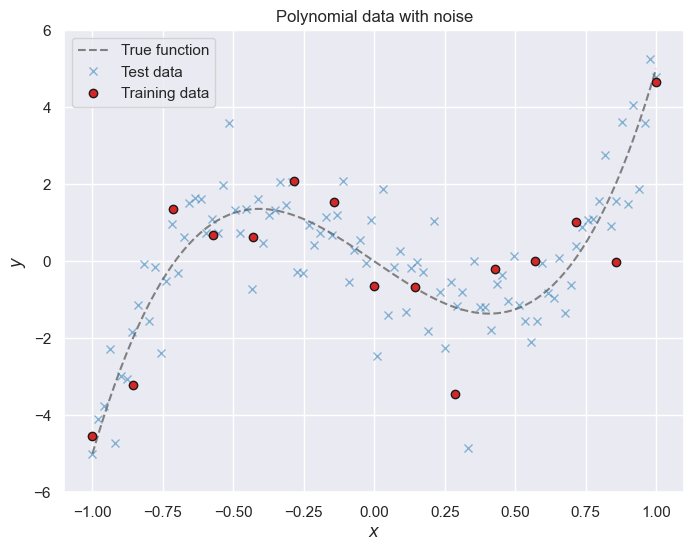

In [69]:
# Set random seed for reproducibility
np.random.seed(1234)

# Define data-generating function
func = lambda x: 10 * x**3 - 5 * x

# Generate training data from polynomial
N_train = 15
X_train = np.linspace(-1, 1, N_train).reshape(-1,1) # Training inputs
y_train = func(X_train) + np.random.randn(N_train).reshape(-1,1) # Training outputs with noise
# Generate test data from polynomial
N_test = 100
X_test = np.linspace(-1,1, N_test).reshape(-1,1) # Test inputs
y_test = func(X_test) + np.random.randn(N_test).reshape(-1,1) # Test outputs with noise

# Define a function for plotting the data
def plot_polynomial_data(X_train, y_train, X_test, y_test, func, plot_test_points=True, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot true function and data points
    ax.plot(X_test, func(X_test), "--", color="gray", label="True function")
    if plot_test_points: # only plot test points if specified
        ax.plot(X_test, y_test, "x", color="tab:blue", label="Test data", alpha=0.5)
    
    # Plot training points
    ax.plot(X_train, y_train, "o", color="tab:red", label="Training data", mec='k')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_ylim(-6, 6)

# Plot the data using the function
fig, ax = plt.subplots(figsize=(8, 6))
plot_polynomial_data(X_train, y_train, X_test, y_test=y_test, func=func, ax=ax)
ax.set_title("Polynomial data with noise")
ax.legend()
plt.show()

**Task 1.1:** Fit a linear regression model with polynomial features to the data.

> *Hint:* We use a polynomial degree that is the same as the number of training points, i.e. $15$.

> *Hint:* Use `model = make_pipeline(PolynomialFeatures(degree), LinearRegression())` to construct a linear regression model with polynomial features.

> *Hint:* Next, fit the model using `model.fit()`.

<br>

**Task 1.2:** Compute the mean squared error (MSE) on the training and test set. The training MSE should be 0 - why is that?

> *Hint:* Remember from the week on overfitting, that a model with equally many parameters as data points perfectly fits the training data.

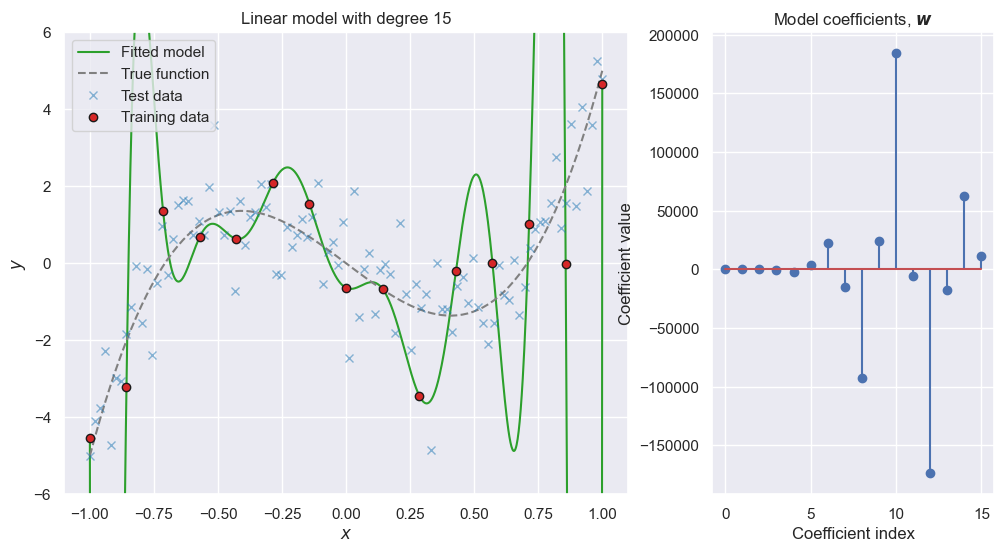

Train MSE: 0.0000 | Test MSE: 1319.1744


In [70]:
degree = N_train

# Create a linear regression model with polynomial features of some degree
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)


# Extract model coefficients
coefs = model.named_steps['linearregression'].coef_.flatten()

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})
# Plot the learned polynomial function
x_grid = np.linspace(-1, 1, 1000).reshape(-1,1)
axs[0].plot(x_grid, model.predict(x_grid), color="tab:green", label=f"Fitted model")
# Re-plot the data
plot_polynomial_data(X_train, y_train, X_test, y_test, func, ax=axs[0])
# Add title and legend
axs[0].set_title(f"Linear model with degree {degree}")
axs[0].legend(loc='upper left')

# Plot the model coefficients
axs[1].stem(coefs)
axs[1].set_title(r"Model coefficients, $\boldsymbol{w}$")
axs[1].set_xlabel("Coefficient index")
axs[1].set_ylabel("Coefficient value")
plt.show()


# Predict on the training and test data and compute MSE
y_pred_train = model.predict(X_train)
mse_train_linreg = mean_squared_error(y_train, y_pred_train)
y_pred_test = model.predict(X_test)
mse_test_linreg = mean_squared_error(y_test, y_pred_test)
print(f'Train MSE: {mse_train_linreg:.4f} | Test MSE: {mse_test_linreg:.4f}')



Currently, we have a very flexible model (high variance) due to the fact that we have as many parameters as training data points. This makes us overfit to the training data. In the beginning of the exercise, we argued that *regularizing* the model weights by enforcing the coefficients/weights to have a low $\ell_2$ norm. This can help us trade-off variance with bias and thereby avoid overfitting.

**Task 1.3:** Introduce regularization by the $\ell_2$-norm on the weights using a regularization strength of $\lambda=0.001$ and repeat the two previous tasks. How does this impact the model visually (model fit and coefficients)? How does this impact the models training and test set errors?

> *Hint:* We need to change the model type to the `sklearn.linear_model.Ridge()` which is equivalent to linear regression with $\ell_2$ regularization. Remark that this function denotes the regularization strength by the input argument `alpha`.

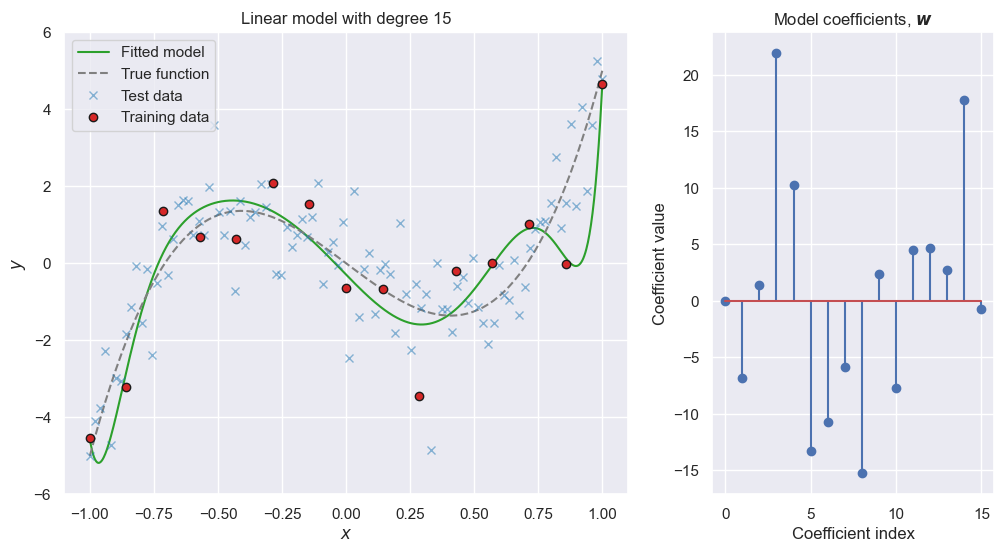

MSE train: 0.6013 | MSE test: 1.6298


In [83]:
degree = N_train
regularization_strength = 0.001

# Create a linear regression model with polynomial features of some degree
model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=regularization_strength))
model.fit(X_train, y_train)


# Extract model coefficients
coefs = model.named_steps['ridge'].coef_.flatten()

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})
# Plot the learned polynomial function
x_grid = np.linspace(-1, 1, 1000).reshape(-1,1)
axs[0].plot(x_grid, model.predict(x_grid), color="tab:green", label=f"Fitted model")
# Re-plot the data
plot_polynomial_data(X_train, y_train, X_test, y_test, func, ax=axs[0])
# Add title and legend
axs[0].set_title(f"Linear model with degree {degree}")
axs[0].legend(loc='upper left')

# Plot the model coefficients
axs[1].stem(coefs)
axs[1].set_title(r"Model coefficients, $\boldsymbol{w}$")
axs[1].set_xlabel("Coefficient index")
axs[1].set_ylabel("Coefficient value")
plt.show()


# Predict on the training and test data and compute MSE
y_pred_train = model.predict(X_train)
mse_ridge_train = mean_squared_error(y_train, y_pred_train)
y_pred_test = model.predict(X_test)
mse_ridge_test = mean_squared_error(y_test, y_pred_test)
print(f'MSE train: {mse_ridge_train:.4f} | MSE test: {mse_ridge_test:.4f}')

The fact that the regularization penalizes large coefficients means that the model has less wiggle-room (lower variance) which prevents the model from overfitting to the training points. This comes at the cost of increasing bias, since the model is constrained from fitting the training data as closely.

**Task 1.4:** What happens to the model fit if you increase the regularization strength $\lambda$ further? Try with $\lambda=0.1$ and $\lambda=10$. Which regularization strength would you choose and why?

> *Hint:* Do we choose the best value for $\lambda$ based on the training set MSE or test set MSE?

> *Hint:* What happens to the bias and variance when you increase the regularization strength?

- *Answer:*

  - Simpler models are less flexible, so they cannot fit training data extremes as closely → bias increases.
  - Because parameters are constrained, fitted models vary less between different training sets → variance decreases



---
## Part 2: Regression on the `body` dataset with regularizaton

In the following, we will see how to regularize a model for predicting a continous target variable using *linear* regression and its regularized version, namely ridge regression that we also considered above. We load the `body` dataset and use the $\left(\boldsymbol{X}, \boldsymbol{y}\right)$ convention. We choose the body weight as the target to learn and use the remaining features as the input data.

**Task 2.1:** Inspect the code cell below. Take a look at the attributes that we keep in the data matrix $\boldsymbol{X}$.

In [17]:
# Load the body dataset
df = pd.read_csv('data/body.csv')
# Display the first few rows of the dataframe
display(df.head())

# Define feature matrix X and target vector y
X = df.drop(columns=['Offset', 'weight']).values
y = df['weight'].values

# Get number of samples and features
N, M = X.shape
print(f"Number of samples: {N}, number of features: {M}")

,Offset,biacromial,pelvic.breadth,bitrochanteric,chest.depth,chest.diam,elbow.diam,wrist.diam,knee.diam,ankle.diam,...,thigh.girth,bicep.girth,forearm.girth,knee.girth,calf.girth,ankle.girth,wrist.girth,age,height,weight
0,1.0,42.9,26.0,31.5,17.7,28.0,13.1,10.4,18.8,14.1,...,51.5,32.5,26.0,34.5,36.5,23.5,16.5,21.0,174.0,65.6
1,1.0,43.7,28.5,33.5,16.9,30.8,14.0,11.8,20.6,15.1,...,51.5,34.4,28.0,36.5,37.5,24.5,17.0,23.0,175.3,71.8
2,1.0,40.1,28.2,33.3,20.9,31.7,13.9,10.9,19.7,14.1,...,57.3,33.4,28.8,37.0,37.3,21.9,16.9,28.0,193.5,80.7
3,1.0,44.3,29.9,34.0,18.4,28.2,13.9,11.2,20.9,15.0,...,53.0,31.0,26.2,37.0,34.8,23.0,16.6,23.0,186.5,72.6
4,1.0,42.5,29.9,34.0,21.5,29.4,15.2,11.6,20.7,14.9,...,55.4,32.0,28.4,37.7,38.6,24.4,18.0,22.0,187.2,78.8


Number of samples: 30, number of features: 23


Notice that we remove the "Offset" attribute (the one related to the intercept) from the training data. This is because `Ridge()` and `LinearRegression()` internally fit the bias separately from the weights. In this way, `Ridge()` only regularizes the coefficients and not the intercept - note that we should **never regularize the bias!**

**Task 2.2:** Why might it be a good idea to add regularization to a linear model trained on the `body` dataset?

> *Hint:* How many observations does the dataset have? How many features?

- *Answer:*
  
  Because there is a lot of variation in human body shapes, so we do not want to overfit the model.

We provide most code for doing two-layer cross-validation on the body data. In the inner loop, 10-fold cross-validation is used to select for the optimal value of regularization $\lambda$. In the outer loop 5-fold cross-validation is used to evaluate the model performance using the optimal selected value for $\lambda$. What the code cell does is to:
1. Define the cross-validation setup and the hyperparameters to test in the inner loop (here, the regularization strengths).
2. Make an outer train-test split of the data.
3. Split the outer training data into an inner train-test split. 
4. Standardize the inner train-test data wrt. the mean and standard deviation of the *inner training data*.
5. For each of the selected hyperparameter settings, train and evaluate a model on the inner data split.
6. Do this for all inner folds, then determine the optimal value of the hyperparameter based on the lowest *average test error across inner folds*.
7. Standardize the outer train-test data based on the mean and standard deviation of the *outer training data*, then train and evaluate a model on this data using the optimal hyperparameter value.
8. Train and evaluate a baseline model on the same dataset split for comparison. Store the result for both approaches. 
9. Repeat the procedure for all outer folds.

**Task 2.3:** Fill in the missing parts of the two-layer cross-validation.

> *Hint:* First task is to standardize the data in the inner fold. Notice where in the code we do this standardization. This is important for not leaking information from the test set dataset into the training dataset which would bias the generalization error.

> *Hint:* Next task is to fit the regularized model. Use the `sklearn.linear_model.Ridge()` model again, now without polynomial features.

> *Hint:* Third, determine the optimal regularization strength based on the average test set error. You can do `optimal_hyperparameter = lambdas[np.argmin(np.mean(test_errors_inner[outer_fold_idx], axis=0))]`.

> *Hint:* Now, standardize the data of the outer fold and train a model with the optimal regularization strength that you just found.

In [86]:
# Set random seed for reproducibility
np.random.seed(1234)

# Create crossvalidation partition for model evaluation
K_outer = 5
CV_outer = model_selection.KFold(K_outer, shuffle=True)

# Create crossvalidation partition for hyperparameter tuning
K_inner = 10
CV_inner = model_selection.KFold(K_inner, shuffle=True)

# Values of regularization parameter lambda to test in the inner loop
lambdas = np.logspace(-5, 8, 14)

# Setup storage for the experiment
optimal_regularization_strengths, ws_inner, train_errors_inner, test_errors_inner, ws_outer, errors_outer = setup_storage_for_experiment(K_outer, K_inner, len(lambdas))

# Run two-layer cross-validation
for outer_fold_idx, (outer_train_index, outer_test_index) in enumerate(CV_outer.split(X, y)):
    # Extract training and test set for the current outer CV fold
    X_train_outer, y_train_outer = X[outer_train_index], y[outer_train_index]
    X_test_outer, y_test_outer = X[outer_test_index], y[outer_test_index]

    # Loop over inner cross-validation folds
    for inner_fold_idx, (inner_train_index, inner_test_index) in enumerate(CV_inner.split(X_train_outer, y_train_outer)):

        # Extract training and validation set for current inner CV fold
        X_train_inner, y_train_inner = X_train_outer[inner_train_index], y_train_outer[inner_train_index]
        X_test_inner, y_test_inner = X_train_outer[inner_test_index], y_train_outer[inner_test_index]

        # Compute the mean and standard deviation of the inner training data split, then standardize training and test sets
        X_train_inner_mean = np.mean(X_train_inner)
        X_train_inner_stdev = np.std(X_train_inner)
        
        scaler = StandardScaler()
        scaler.fit(X_train_inner)
        X_train_inner = scaler.transform(X_train_inner)
        X_test_inner = scaler.transform(X_test_inner)
        
        # Loop over all values of lambda
        for lambda_idx, regularization_strength in enumerate(lambdas):

            # Create and fit the model
            model = Ridge(alpha=regularization_strength)
            model.fit(X_train_inner, y_train_inner)

            # Store the model coefficients for each value of lambda in the inner folds
            ws_inner[:, outer_fold_idx, inner_fold_idx, lambda_idx] = [model.intercept_] + model.coef_.flatten().tolist()

            # Compute and store the training and validation error
            train_errors_inner[outer_fold_idx, inner_fold_idx, lambda_idx] = np.mean((y_train_inner - model.predict(X_train_inner))**2, axis=0)
            test_errors_inner[outer_fold_idx, inner_fold_idx, lambda_idx] = np.mean((y_test_inner - model.predict(X_test_inner))**2, axis=0)
    
    # Determine the optimal value of lambda that gives the lowest test error on average from the inner folds
    optimal_hyperparameter = lambdas[np.argmin(np.mean(test_errors_inner[outer_fold_idx], axis=0))]

    # Store the optimal regularization strength for the current outer fold
    optimal_regularization_strengths[outer_fold_idx] = optimal_hyperparameter

    # Compute the mean and standard deviation of the outer training data split, then standardize the training and test sets
    X_train_outer_mean = np.mean(X_train_outer)
    X_train_outer_stdev = np.std(X_train_outer)

    scaler = StandardScaler()
    scaler.fit_transform(X_train_outer)
    X_train_outer = scaler.transform(X_train_outer)
    X_test_outer = scaler.transform(X_test_outer)

    # Create and fit the model with the optimal lambda on the entire outer training set
    model = Ridge(alpha=optimal_hyperparameter)
    model.fit(X_train_outer, y_train_outer)

    # Store the model coefficients for the regularized model
    ws_outer['regularized'][:, outer_fold_idx] = [model.intercept_] + model.coef_.flatten().tolist()
    # Compute and store the training and test error for the regularized model
    errors_outer['train']['regularized'][outer_fold_idx] = np.mean((y_train_outer - model.predict(X_train_outer))**2, axis=0)
    errors_outer['test']['regularized'][outer_fold_idx] = np.mean((y_test_outer - model.predict(X_test_outer))**2, axis=0)


    # Create and fit a model without regularization on the entire outer training set, for comparison
    model = LinearRegression()
    model.fit(X_train_outer, y_train_outer)

    # Store the model coefficients for the model without regularization
    ws_outer['not regularized'][:, outer_fold_idx] = [model.intercept_] + model.coef_.flatten().tolist()
    # Compute and store the training and test error for the model without regularization
    errors_outer['train']['not regularized'][outer_fold_idx] = np.mean((y_train_outer - model.predict(X_train_outer))**2, axis=0)
    errors_outer['test']['not regularized'][outer_fold_idx] = np.mean((y_test_outer - model.predict(X_test_outer))**2, axis=0)

    # Compute mean squared error for the baseline, i.e. without using the input data at all
    errors_outer['train']['baseline (no features)'][outer_fold_idx] = np.mean((y_train_outer - y_train_outer.mean())**2, axis=0)
    errors_outer['test']['baseline (no features)'][outer_fold_idx] = np.mean((y_test_outer - y_test_outer.mean())**2, axis=0)

# Print results
print_regularization_results(errors_outer)

Linear regression without regularization:
- Training error: 	0.0000
- Test error: 		352.6788
- R^2 train: 		1.0000
- R^2 test: 		-5.4620

Regularized linear regression:
- Training error: 	1.3975
- Test error: 		7.6763
- R^2 train: 		0.9798
- R^2 test: 		0.8594



**Task 2.4:** Try to inspect the weights obtained when using a very high regularization strength. What has happened to the value of the coefficients and what does the intercept now represent? Verify that the intercept has not been regularized.

> *Hint:* The weights found in each inner fold are stored in the `ws_inner` array. Try to type `ws_inner.shape` to figure out how to extract the weights from the last inner fold of the last outer fold.

> *Hint:* Which index corresponds to a very high regularization strength?

> *Hint:* Try to compare the mean of the target variable in the training set to the parameters that have been fitted.

> *Hint:* If you get stuck, you can get the weights associated to the highest regularization strength as `ws_inner[:, selected_outer_fold, selected_inner_fold, -1]`. Which index of the resulting array corresponds to the intercept?

In [102]:
selected_inner_fold = -1
selected_outer_fold = -1

# Get the weights for the selected outer and inner fold from ws_inner. Compare the bias term to the mean of the target variable in the training set.
print(f"Weights for outer fold {selected_outer_fold} and inner fold {selected_inner_fold}:")
# Extract and print the weights for the selected fold
print(ws_inner[:, selected_outer_fold, selected_inner_fold, -1])

# Print the mean of the target variable in the training set for the last inner fold of the last outer fold
print(f"\nMean of target variable in training set: {np.mean(y_train_inner):.5f}")
# Compare the bias term (first entry) to the mean of the target variable
print(f"Bias term (intercept) from model: {ws_inner[0, selected_outer_fold, selected_inner_fold, -1]:.5f}")

Weights for outer fold -1 and inner fold -1:
[7.57545455e+01 4.77980869e-07 1.46512844e-06 1.32352277e-06
 1.26833340e-06 1.08949896e-06 1.36277782e-06 1.24763607e-06
 1.34262288e-06 1.38487481e-06 1.19242641e-06 1.32294544e-06
 1.60438193e-06 1.24624363e-06 1.67491189e-06 1.71902064e-06
 1.46325207e-06 1.46701582e-06 1.44762594e-06 1.64463588e-06
 9.09309340e-07 1.41271390e-06 1.02120366e-06 1.16182324e-06]

Mean of target variable in training set: 75.75455
Bias term (intercept) from model: 75.75455


The output from above only gives us a sense of how a high regularization strength impacts the model weights in a specific inner fold. Below, we take a closer look at how the optimal hyperparameter value - the one that best trades off bias and variance - can be selected from the inner cross-validation loop and how the associated regularization strength impacts the model coefficients.

**Task 2.5:** What is plotted on each of the generated plots? How is the optimal value of the regularization ($\lambda$) chosen? 

- *Answer:*

- 1st plot: Weights values for each regularization value lambda. 2nd plot: train and test error for each regularization lambda.
- Optimal lambda is chosen by comparing MSE on test data - picking the lambda at the function minimum.

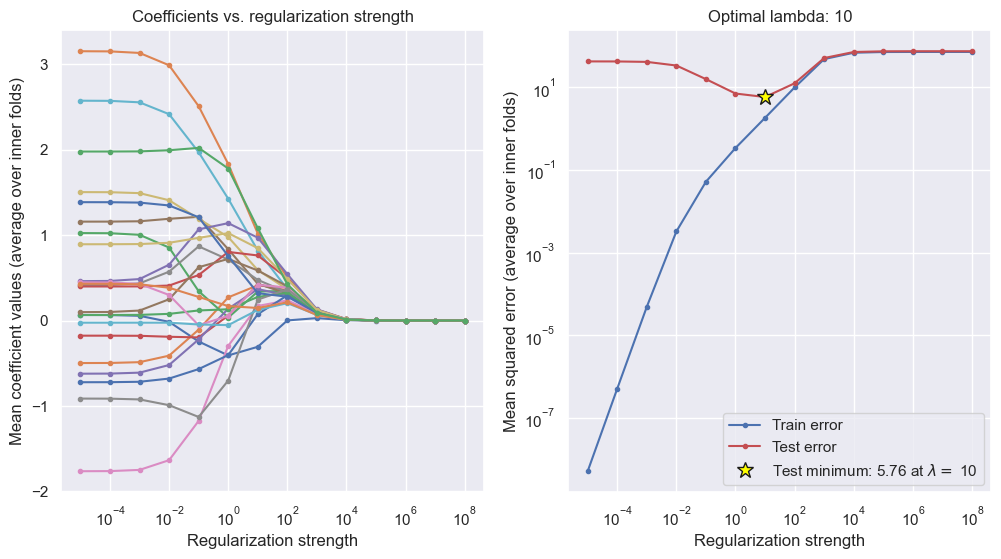

In [103]:
# Compute the mean training and validation error across inner folds for the selected outer fold
train_err_vs_lambda = np.mean(train_errors_inner[selected_outer_fold], axis=0)
test_err_vs_lambda = np.mean(test_errors_inner[selected_outer_fold], axis=0)

# Compute the mean coefficients across inner folds for the selected outer fold
mean_w_vs_lambda = np.squeeze(np.mean(ws_inner[:, selected_outer_fold, :, :], axis=1))


# Setup figure
plt.figure(figsize=(12, 6))

# Plot the mean coefficients across inner folds vs regularization strength for the selected outer fold
plt.subplot(1, 2, 1)
plt.title("Coefficients vs. regularization strength")
plt.semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
plt.xlabel("Regularization strength")
plt.ylabel("Mean coefficient values (average over inner folds)")

# Plot the mean training and validation error vs regularization strength for the selected outer fold
plt.subplot(1, 2, 2)
plt.title(f"Optimal lambda: {optimal_regularization_strengths[selected_outer_fold]:.2g}")
plt.loglog(lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-")
plt.semilogx(optimal_regularization_strengths[selected_outer_fold], test_err_vs_lambda.min(), "*", color='yellow', markersize=12, markeredgecolor='k')
plt.xlabel("Regularization strength")
plt.ylabel("Mean squared error (average over inner folds)")
plt.legend(["Train error", "Test error", r"Test minimum: {:.2f} at $\lambda=$ {:.2g}".format(test_err_vs_lambda.min(), optimal_regularization_strengths[selected_outer_fold])])
plt.show()

We now take a closer look at the parameters of the models *after* training with the optimal hyperparameter. That is the models trained in each of the outer folds. In the code cell below, we collect the optimal parameters in two dataframes for the regularized and unregularized models from each outer fold.

In [104]:
# Create dataframes for the weights obtained in each outer fold for the regularized and unregularized models
unregularized = pd.DataFrame(ws_outer['not regularized'], index=df.columns[:-1], columns=[f'Outer fold {i+1}' for i in range(K_outer)]).T
regularized = pd.DataFrame(ws_outer['regularized'], index=df.columns[:-1], columns=[f'Outer fold {i+1}' for i in range(K_outer)]).T

display(unregularized, regularized)

,Offset,biacromial,pelvic.breadth,bitrochanteric,chest.depth,chest.diam,elbow.diam,wrist.diam,knee.diam,ankle.diam,...,hip.girth,thigh.girth,bicep.girth,forearm.girth,knee.girth,calf.girth,ankle.girth,wrist.girth,age,height
Outer fold 1,78.470833,-1.281816,-2.616268,2.783051,-2.968093,0.850313,-0.319637,-0.140467,3.721703,-2.147117,...,-7.675672,2.336762,7.678265,-5.448490,3.893604,3.683913,-1.862269,0.017326,-2.398771,1.899758
Outer fold 2,77.562500,-3.182549,-4.958798,12.151755,-5.265877,-5.968181,-9.294440,-1.074121,-0.840995,9.809877,...,-6.716681,10.567743,-4.831672,-1.090874,-4.639491,0.141018,-7.737920,13.818357,-6.165181,4.178209
Outer fold 3,77.558333,18.205341,-1.262931,-36.104370,19.742356,9.894055,27.924936,-11.840345,11.173280,-0.154377,...,27.264722,-36.294287,34.857578,-21.992278,11.733140,20.794503,0.455214,-32.429452,8.503348,-3.735161
Outer fold 4,76.441667,0.706322,-2.600223,2.778784,1.104357,-1.011087,0.529662,-1.096063,1.260390,2.541527,...,1.278123,-0.919930,-1.936072,3.223189,-0.808615,1.241369,-2.322780,0.069566,-0.711556,0.909938
Outer fold 5,75.650000,3.615698,-3.392349,5.873808,0.351052,-6.218830,2.124496,-3.063869,-6.150777,5.033895,...,-1.553255,-2.771828,-5.492300,3.445244,0.947445,2.437066,1.354932,-0.108781,3.103415,1.833575


,Offset,biacromial,pelvic.breadth,bitrochanteric,chest.depth,chest.diam,elbow.diam,wrist.diam,knee.diam,ankle.diam,...,hip.girth,thigh.girth,bicep.girth,forearm.girth,knee.girth,calf.girth,ankle.girth,wrist.girth,age,height
Outer fold 1,78.470833,-0.110571,0.132365,0.311190,0.328062,0.383431,0.087387,0.119257,0.634260,0.491411,...,0.673962,0.943922,0.352277,0.280890,0.588349,1.003333,0.285056,0.231494,0.028983,1.163081
Outer fold 2,77.562500,0.629757,-1.189953,-0.360029,-0.500952,-0.436132,0.321328,-1.151595,1.477528,1.563060,...,1.477159,1.285579,-0.133879,0.820843,0.214454,0.494281,-0.543097,1.159424,0.183690,2.562148
Outer fold 3,77.558333,0.297222,0.302152,0.370624,0.743000,0.430118,0.318343,0.196988,0.587076,0.608590,...,0.726136,1.161823,0.305542,0.218598,0.510918,0.675315,0.216077,0.390469,0.206216,0.768809
Outer fold 4,76.441667,0.211373,0.166809,0.591308,0.554049,0.602964,0.117312,-0.134236,0.460095,0.021974,...,0.786708,0.645842,0.114889,0.465517,0.289540,0.741573,0.091164,0.518822,-0.081777,1.120819
Outer fold 5,75.650000,-0.342857,0.401375,0.317974,0.403632,0.354723,0.444319,0.165531,0.487031,0.618374,...,0.770635,0.998012,0.601883,0.392735,0.201283,0.880529,0.118157,0.329921,0.143639,1.144576


**Task 2.6:** Compare the weights of the regularized model to the unregularized by computing the $\ell_2$ norm of the weights for each outer fold. Plot them in a bar plot.

> *Hint:* Use `np.linalg.norm(DATAFRAME, ord=2)`to compute the $\ell_2$ norm of the `unregularized` and `regularized` dataframes.

> *Hint:* Do not include the model intercept in the analysis. What would happen if we did? Think about how restricting the weights with regularization will impact the intercept.

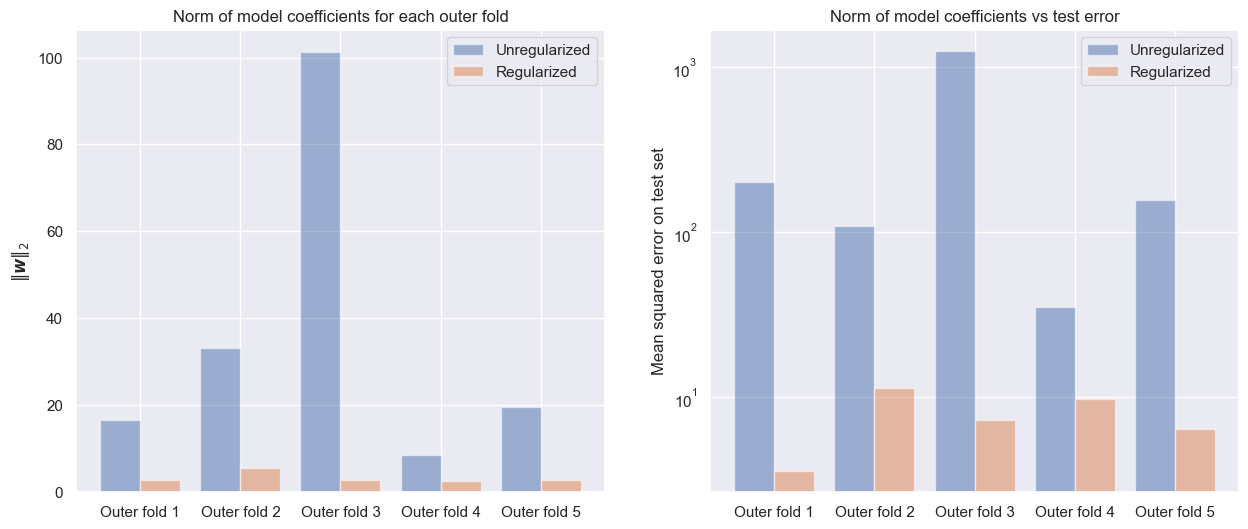

In [106]:
# Compute the L2 norm of the model coefficients for each outer fold (excluding the intercept) for the regularized and unregularized model
unregularized_norm = np.linalg.norm(unregularized.iloc[:, 1:], ord=2, axis=1)
regularized_norm = np.linalg.norm(regularized.iloc[:, 1:], ord=2, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
# Plot the L2 norms
axs[0].bar(np.arange(K_outer)-0.2, np.linalg.norm(unregularized.iloc[:, 1:], axis=1), width=0.4, alpha=0.5, label='Unregularized')
axs[0].bar(np.arange(K_outer)+0.2, regularized_norm, width=0.4, alpha=0.5, label='Regularized')
axs[0].set_ylabel(r'$\|\boldsymbol{w}\|_2$')
axs[0].set_xticks(ticks=np.arange(K_outer), labels=unregularized.index, rotation=0)
axs[0].set_title('Norm of model coefficients for each outer fold')
axs[0].legend()

axs[1].bar(np.arange(K_outer)-0.2, errors_outer['test']['not regularized'].flatten(), width=0.4, alpha=0.5, label='Unregularized')
axs[1].bar(np.arange(K_outer)+0.2, errors_outer['test']['regularized'].flatten(), width=0.4, alpha=0.5, label='Regularized')
axs[1].set_xticks(ticks=np.arange(K_outer), labels=unregularized.index, rotation=0)
axs[1].set_ylabel('Mean squared error on test set')
axs[1].set_yscale('log')
axs[1].set_title('Norm of model coefficients vs test error')
axs[1].legend()
plt.show()

**Task 2.7:** What do you think may be the advantages and disadvantages of regularized linear regression compared to the sequential feature selection? 

> *Hint:*

- *Answer:*


---
## Part 3: Classifying the `wine` dataset with regularizaton

We now consider a classification problem of predicting a binary class label with *logistic* regression as well as a regularized version of this. We load the `wine` dataset and use the $\left(\boldsymbol{X}, \boldsymbol{y}\right)$ convention. We choose the wine color as the classification target and use the remaining features as the input data.

**Task 3.1:** Inspect the code cell below. Take a look at the attributes from the data matrix $\boldsymbol{X}$.

In [107]:
# Load the wine dataset
df = pd.read_csv('data/wine.csv')
display(df.head())

# Define feature matrix X and target vector y
X = df.drop(columns=['Color'])
y = df['Color']

# Get number of samples and features
N, M = X.shape
print(f"Number of samples: {N}, number of features: {M}")

,Fixed acidity,Volatile acidity,Citric acid,Residual sugar,Chlorides,Free sulfur dioxide,Total sulfur dioxide,Density,pH,Sulphates,Alcohol,Color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0


Number of samples: 6304, number of features: 11


**Task 3.2:** Why might regularization not have as strong an effect on the model as it had for the `body` dataset?

> *Hint:* Again, how many observations does the dataset have? How many features?

- *Answer:*

The Wine dataset is relatively large, so we train on only a small part of the dataset (5%) to illustrate the effect of regularization on small datasets. 

**Task 3.3:** Train a model that predicts whether a data point is a red or a white wine. Standardize the data based on the training set features means and standard deviations. Determine a suitable regularization strength using hold-out cross-validation.

> *Hint:* Notice, that the task is only related to hyperparameter selection, hence we do not need a two-layer cross-validation setup here.

> *Hint:* In the code, we *stratify* the hold-out split. This essentially ensures that the distribution of the target label is approximately equal in the original dataset, the training split and the test splits.

> *Hint:* The `LogisticRegression` model from `sklearn` defines the regularization strength as `C=1/lambda`. Hence you need to define `model = LogisticRegression(penalty="l2", C=1/regularization_strength)`.

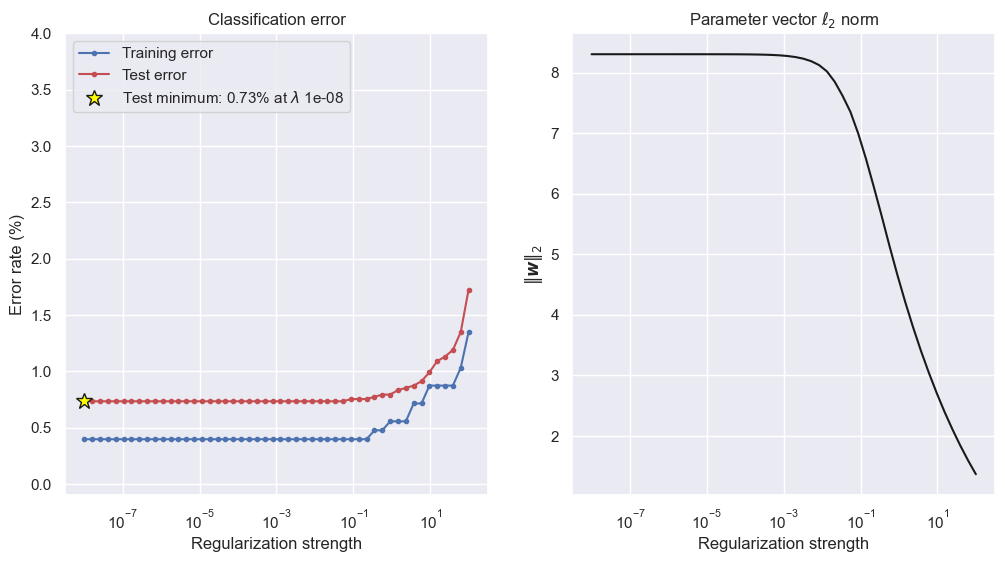

In [117]:
# Create crossvalidation partition for evaluation using stratification and 95 pct. split between training and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.80, stratify=y)

# Compute the mean and standard deviation of the training data split, then standardize the training and test sets
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Select the range of regularization strengths to test
lambdas = np.logspace(-8, 2, 50)

# Setup storage for quantities computed in the experiment
train_error_rate = np.zeros(len(lambdas))
test_error_rate = np.zeros(len(lambdas))
coefficient_norm = np.zeros(len(lambdas))

# Loop over all values of the regularization strength
for i, regularization_strength in enumerate(lambdas):

    # Create and fit the regularized logistic regression model on the training set using the current regularization strength
    model = LogisticRegression(penalty="l2", C=1/regularization_strength)
    model.fit(X_train, y_train)

    # Predict on training and test set
    y_train_est = model.predict(X_train).T
    y_test_est = model.predict(X_test).T

    # Compute and store the training and test error rates
    train_error_rate[i] = np.sum(y_train_est != y_train) / len(y_train)
    test_error_rate[i] = np.sum(y_test_est != y_test) / len(y_test)

    # Compute and store the L2 norm of the model coefficients
    coefficient_norm[i] = np.linalg.norm(model.coef_, ord=2)

# Find the minimum test error and the corresponding regularization strength
min_error = np.min(test_error_rate)
opt_lambda_idx = np.argmin(test_error_rate)
opt_lambda = lambdas[opt_lambda_idx]

# Plot the results
fig, axs = plt.subplots(1,2, figsize=(12, 6))
axs[0].semilogx(lambdas, train_error_rate * 100, 'b.-')
axs[0].semilogx(lambdas, test_error_rate * 100, 'r.-')
axs[0].semilogx(opt_lambda, min_error * 100, "*", color='yellow', markersize=12, markeredgecolor='k')
axs[0].set_xlabel("Regularization strength")
axs[0].set_ylabel("Error rate (%)")
axs[0].set_title("Classification error")
axs[0].set_ylim([-0.1, 4])
axs[0].legend(["Training error", "Test error", fr"Test minimum: {min_error*100:.2f}% at $\lambda$ {opt_lambda:.2g}"], loc="upper left")

axs[1].semilogx(lambdas, coefficient_norm, "k")
axs[1].set_ylabel("$\\|\\boldsymbol{w}\\|_2$")
axs[1].set_xlabel("Regularization strength")
axs[1].set_title(r"Parameter vector $\ell_2$ norm")
plt.show()

**Task 3.4:** Try to change the percentage of data used for training (try e.g. 50% and 99%). Does this influence your conclusions about the optimal regularization strength?

> *Hint:* Run the code multiple times to see how much the subset affects the performance when reducing the training set size.

**Task 3.5:** How is the magnitude of the fitted parameters affected by the regularization strength?

- *Answer:* 

<br>


---
## Part 4: Ensemble methods

In this part of the exercise we will consider ensemble methods to improve the classification performance. In particular we will consider bagging and boosting methods. Each method combine the predictions of multiple weak learners (simple models) by doing *majority votng*.

#### Bagging - bootstrap aggregating

In bagging we randomly sample with replacement the same number of samples as the size of the training data. This is also denoted bootstrapping and it can be shown that on average each bootstrap sample will contain approximately 63% of the samples in the data.

**Task 4.1:** How does bagging influence the variance of the model? What happens to the model bias when doing bagging using a weak learner?

> *Hint:* What do you think happens to the variance when *averaging* the predictions of many models?

> *Hint:* A weak learner has a high bias. Do you think averaging many models that do not work well can improve the model fit?

> *Hint:* You will find the answer at the end of todays exercise.

- *Answer:* 

In the following, we will work with a synthetic data set which has two classes and two attributes, $x_1$ and $x_2$. This data set cannot be classified correctly with any linear classifier such as logistic regression as long as only $x_1$ and $x_2$ are used as features. We visualize the dataset below.

,x1,x2,y
0,0.923983,0.375663,1.0
1,0.286681,0.167146,1.0
2,0.575814,0.451366,0.0
3,0.660464,0.070620,1.0
4,0.150924,0.258054,1.0


Number of samples: 500, number of features: 2


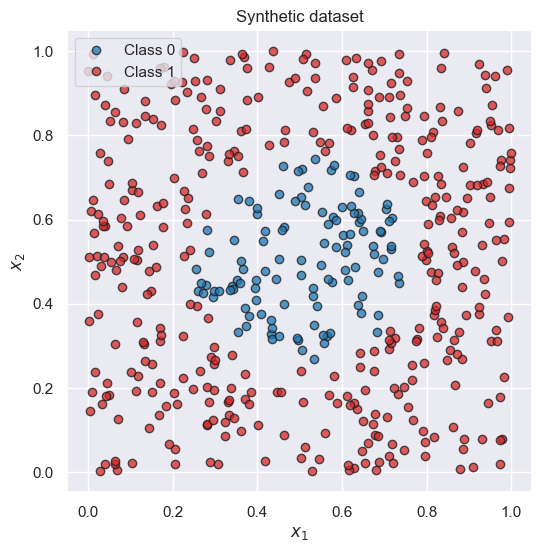

In [132]:
dataset_name = 'synth7'

# Load the synthetic dataset
df = pd.read_csv(f'data/{dataset_name}.csv')
display(df.head())

# Define feature matrix X and target vector y
X = df.drop(columns=['y']).values
y = df['y'].values

# Get number of samples and features
N, M = X.shape
print(f"Number of samples: {N}, number of features: {M}")

# Plot the data
fig = plt.figure(figsize=(6,6))
for label in np.unique(y):
    mask = (y == label)
    plt.plot(X[mask, 0], X[mask, 1], 'o', label=f'Class {int(label)}', alpha=0.75, color=('tab:blue' if label == 0 else 'tab:red'), mec='k')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Synthetic dataset')
plt.legend(loc='upper left')
plt.show()

A critical part of ensemble methods is how we sample the dataset with bootstrapping.

**Task 4.2:** Fill in the missing parts in the bootstrap function.

> *Hint:* To generate the bootstrap sample, you need to draw $N$ data objects with replacement from the data set. You can use `selected_indices = np.random.choice(range(X.shape[0]), size=(N, 1), replace=True, p=weights).flatten()`.

> *Hint:* For bagging we assume a uniform weight distribution over data points, but we need to be able to define per-data-point weights when doing *boosting* later on. This is what the `p` parameter defines.

In [133]:
def bootstrap(X, y, N, weights="auto"):
    if type(weights) is str and weights == "auto":
        weights = np.ones(X.shape[0], dtype=float) / X.shape[0]
    else:
        weights = np.array(weights, dtype=float)
        weights = (weights / weights.sum()).ravel().tolist()

    selected_indices = np.random.choice(range(X.shape[0]), size=(N, 1), replace=True, p=weights).flatten()
    return X[selected_indices, :], y[selected_indices]

**Task 4.3:** Use $L=100$ bootstrap samples. This requires creating $L=100$ bootstrapped training sets, fit a logistic regression model to each, and combine the results of their outputs to make the final classification. Explain how the error rate is computed (on the training set) and evaluate the performance of the ensemble based on the plotted decision boundary.

> *Hint:* Loop over ensemble members. For each, use the function `bootstrap()` to generate random bootstrapped training sets.

> *Hint:* To make the final classification, take a majority vote amongst the classifiers in the ensemble. Use `y_est_ensemble = votes > (L / 2)`. Make sure you understand what `votes` contain.

> *Hint:* To plot the decision boundary, you can use the function `plot_decision_boundary()`. It requires as an input a function for what to base the decision boundary on, e.g. a `predict_proba_fn` that predicts the probability of belonging to the positive class.

> *Hint:* Bagging is known to be most effective for non-linear classifiers. Show that bagging does not improve the model performance when part of an ensemble.

Ensemble error rate: 22.60%
Minimum individual classifier error rate: 100.00%
Maximum individual classifier error rate: 100.00%


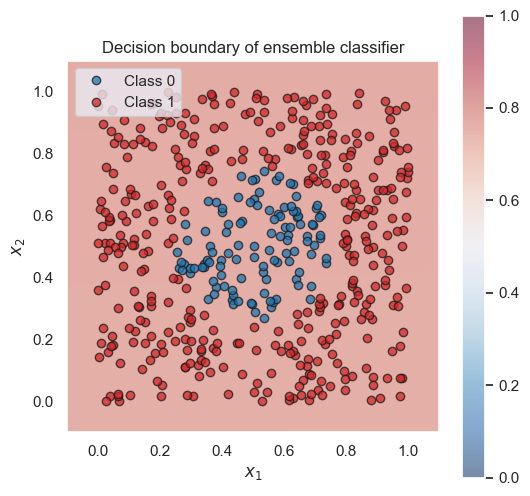

In [136]:
from sklearn.tree import DecisionTreeClassifier


# Number of rounds of bagging
L = 100

# Storage of trained log.reg. classifiers fitted in each bootstrap + their error rates
learners = np.zeros((L), dtype=object)
error_rates = np.zeros((L,))

# Storage for the votes from each classifier
votes = np.zeros((N,))

# For each round of bagging
for i in range(L):

    # Extract X_train and y_train by random sampling with replacement from X and y (i.e. bootstrap)
    X_train, y_train = bootstrap(X, y, N)

    # Fit logistic regression model to training data
    learner = LinearRegression()
    learner.fit(X_train, y_train)

    # Store the learner in the array
    learners[i] = learner

    # Predict on the entire dataset
    y_est = learner.predict(X).T
    
    # Update the votes of the ensemble
    votes = votes + y_est

    # Compute error rate for the current learner
    error_rates[i] = (y != y_est).sum(dtype=float) / N

# Define the ensemble prediction y_est_ensemble by majority voting of the class labels (using 0.5 as threshold)
y_est_ensemble = votes > (L / 2)

# Compute error rate
error_rate_ensemble = (y != y_est_ensemble).sum(dtype=float) / N

# Print the results instead
print(f'Ensemble error rate: {error_rate_ensemble*100:.2f}%')
print(f'Minimum individual classifier error rate: {error_rates.min()*100:.2f}%')
print(f'Maximum individual classifier error rate: {error_rates.max()*100:.2f}%')


# Define a function that computes the mean predicted probability of class 1 over all learners in the ensemble
predict_proba_fn = lambda x: np.mean([learner.predict(x) for learner in learners], axis=0)

# Plot the results
fig = plt.figure(figsize=(6, 6))
# Plot the decision boundary by evaluating the ensemble classifier on a grid of points
plot_decision_boundary(predict_proba_fn, X, threshold=0.5, cmap='RdBu_r', ax=fig.gca(), fig=fig)
# Re-plot the data points
for label in np.unique(y):
    mask = (y == label)
    plt.plot(X[mask, 0], X[mask, 1], 'o', label=f'Class {int(label)}', alpha=0.75, color=('tab:blue' if label == 0 else 'tab:red'), mec='k')

# Add title and legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Decision boundary of ensemble classifier')
plt.legend(loc='upper left')
plt.gca().set_aspect('equal')
plt.show()

We will now try to use a different learner in the ensemble, namely the decision tree which is a non-linear model.

**Task 4.4:** The data set `data/synth5` we have used so far can trivially be fitted using a decision tree. Can you explain why? 

> *Hint:* Consider how the decision tree splits the input space based on its decision rules.


**Task 4.5:** Go back and change the dataset to `synth6`. Additionally change the underlying learner to be a `DecisionTreeClassifier`. What happens to the model performance when compared to using `LogisticRegression` as the ensemble learner.

> *Hint:* Remember, you can get the decision tree as `from sklearn.tree import DecisionTreeClassifier`. Then replace `model = LogisticRegression()` by this new model.

We just defined our model as a collection of decision trees. This is essentially a *random forest classifier* and is already implemented in the `sklearn.ensemble` module.

**Task 4.6:** Below, reimplement the previous example using the `RandomForestClassifier` class. Verify that the result is similar to the solution using multiple `DecisionTreeClassifier`s from above.

> *Hint:* You can get the model as `sklearn.ensemble.RandomForestClassifier`.

> *Hint:* The model takes an argument called `n_estimators`, that is the number of members in the ensemble.

Error rate: 0.00%


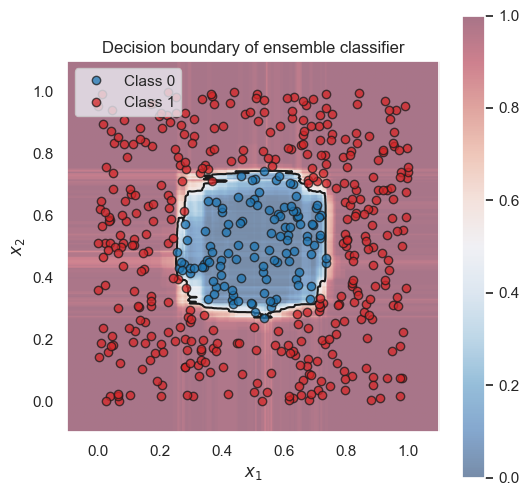

In [137]:
from sklearn.ensemble import RandomForestClassifier

# Number of rounds of bagging
L = 100

# Define and fit a random forest classifier to the entire dataset
model = RandomForestClassifier(n_estimators=L)
model.fit(X, y)

# Predict on the entire dataset
y_est_ensemble = model.predict(X).T
# Get the predicted probabilities for each class
y_est_prob = model.predict_proba(X).T

# Compute error rate
error_rate_ensemble = (y != y_est_ensemble).sum(dtype=float) / N
print('Error rate: {:.2f}%'.format(error_rate_ensemble * 100))


# Define a function that computes the mean predicted probability of class 1 over all learners in the ensemble
predict_proba_fn = lambda x: model.predict_proba(x)[:, 1]

# Plot the results
fig = plt.figure(figsize=(6, 6))
# Plot the decision boundary by evaluating the ensemble classifier on a grid of points
plot_decision_boundary(predict_proba_fn, X, threshold=0.5, cmap='RdBu_r', ax=fig.gca(), fig=fig)
# Re-plot the data points
for label in np.unique(y):
    mask = (y == label)
    plt.plot(X[mask, 0], X[mask, 1], 'o', label=f'Class {int(label)}', alpha=0.75, color=('tab:blue' if label == 0 else 'tab:red'), mec='k')

# Add title and legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Decision boundary of ensemble classifier')
plt.legend(loc='upper left')
plt.gca().set_aspect('equal')
plt.show()

**Task 4.7:** Experiment with the number of ensemble members. What happens to the decision boundary and underlying probabilities if you only have $L=3$ ensemble members? What if you have $L=1000$ members?

**Task 4.8:** Go back and change the experiment to run on the `synth7` dataset. Explore the data set and fit the random forest classifier to the data and comment on the model fit. Explain in what sense this is more challenging for a single decision tree.

- *Answer:*

**Task 4.9:** For comparison, try also to fit a single regular decision tree (without bagging or pruning). Does bagging appear to improve on the classification, and if so, in what sense? 

> *Hint:* You can do this easily by only replacing the definition of the model in the previous cell.

### Boosting
We now turn our attention towards *boosting* instead of bagging. In boosting we iteratively change the distribution that we sample the training examples from so that the classifiers will focus on examples that are hard to classify. A particularly well known boosting method is `AdaBoost` (described in Algorithm 7 in the lecture notes *Introduction to Machine Learning and Data Mining*) where the ensemble's prediction accounts for the error rate per learner when doing the prediction.

<p align="center">
  <img src="adaboost.png" alt="AdaBoost algorithm" height="300px">
</p>
<br>

**Task 4.10:** How does boosting influence the bias of the model? What happens to the model variance when doing boosting using a weak learner?

> *Hint:* What do you think happens to the bias when we iteratively focus on training data that the model does not perform well on?

> *Hint:* You will find the answer in the end of todays exercise.

- *Answer:* 

**Task 4.11:** Fit an ensemble of logistic regression models to the data, using $L=100$ rounds of the `AdaBoost` algorithm. Evaluate the performance of the ensemble based on the error rate and plotted decision boundary.

> *Hint:* This requires 1) creating a randomly chosen training set, 2) fitting a logistic regression model to it, 3) evaluating its performance and updating the weights accordingly, and 4) computing a classifier importance. 

> *Hint:* The process is repeated $L=100$ times, and ultimately the trained ensemble of classifiers is combined to make a final classification. 

> *Hint:* Note that you will need to define and update two sets of weights in the algorithm. One is a weight for each of the $N$ data objects, that is adapted when the boosting algorithm proceeds (we could call these `weights`). The other is the importance weights for the $L=100$ trained classifiers (we could call these `alphas`). 

> *Hint:* We now use the function `bootstrap()` to generate random numbers from a discrete distribution with the per-data-point weight defined by `weights`, in every iteration.

> *Hint:* To make the final classification, take a weighted majority vote amongst the classifiers in the ensemble (weighted by `alpha`). Note that `alpha` needs to be normalized so that it sums to one. Then use `y_est_ensemble = (y_all_learners @ alphas) > 0.5`.

Ensemble error rate: 0.00%
Minimum individual classifier error rate: 22.60%
Maximum individual classifier error rate: 77.40%


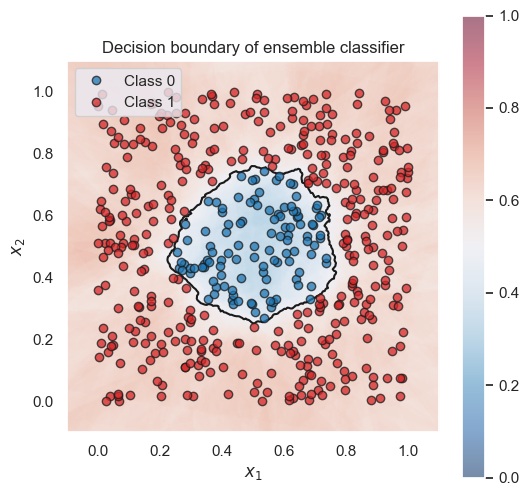

In [142]:
# Number of rounds of boosting
L = 1000

# Weights for selecting samples in each bootstrap
weights = np.ones((N,),dtype=float)/N
# Weights for combining classifiers in the ensemble
alphas = np.ones((L,))

# Storage of trained log.reg. classifiers fitted in each bootstrap + their error rates + predictions
learners = np.zeros((L), dtype=object)
error_rates = np.zeros((L,))
y_all_learners = np.zeros((N,L))

# Storage for the votes from each classifier
votes = np.zeros((N,))

# Error of each classifier
epsilon = 0

# For each round of boosting
for i in range(L):
    # Extract training set by random sampling with replacement from X and y
    while True: 
        # not a thing of beauty, however logistic regression fails if presented with less than two classes. 
        X_train, y_train = bootstrap(X, y, N, weights) 
        if np.unique(y_train).__len__() > 1 : break      
    
    # Fit logistic regression model to training data
    learner = LogisticRegression()
    learner.fit(X_train, y_train)
    # Store the learner in the array
    learners[i] = learner

    # Predict on the entire dataset
    y_est = learner.predict(X).T
    # Store the predictions of this learner
    y_all_learners[:, i] = y_est

    # Update the votes of the ensemble
    votes = votes + y_est

    # Determine if the estimate is correct (0) or not (1)
    correct_predictions = (y_est != y).T
    
    # Store the error rate for the current learner
    error_rates[i] = correct_predictions.sum(dtype=float) / N 

    # Compute the error rate for the current learner
    epsilon = np.multiply(weights, correct_predictions).sum()
    
    # Compute the alpha weight for the current learner
    alpha = 0.5 * np.log((1-epsilon) / epsilon)
    alphas[i] = alpha
    
    # Update the weights for selecting samples in the next round
    weights[y_est == y] = weights[y_est == y] * np.exp(-alphas[i])
    weights[y_est != y] = weights[y_est != y] * np.exp(alphas[i])
    
    # Normalize the weights
    weights = weights / sum(weights)

# Estimated value of class labels (using 0.5 as threshold) by majority voting
alphas = alphas / sum(alphas)
y_est_ensemble = (y_all_learners @ alphas) > 0.5

# Compute error rate
error_rate_ensemble = (y != y_est_ensemble).sum(dtype=float) / N

# Print the results instead
print(f'Ensemble error rate: {error_rate_ensemble*100:.2f}%')
print(f'Minimum individual classifier error rate: {error_rates.min()*100:.2f}%')
print(f'Maximum individual classifier error rate: {error_rates.max()*100:.2f}%')


# Define a function to compute the weighted vote of the ensemble
def predict_proba_fn(X):
    votes = np.zeros((X.shape[0], 1))
    for learner_idx, learner in enumerate(learners):
        y_est = np.asmatrix(learner.predict(X)).T
        votes = votes + y_est * alphas[learner_idx]
    return votes.astype(float)


# Plot the results
fig = plt.figure(figsize=(6, 6))
# Plot the decision boundary by evaluating the ensemble classifier on a grid of points
plot_decision_boundary(predict_proba_fn, X, threshold=0.5, cmap='RdBu_r', ax=fig.gca(), fig=fig)
# Re-plot the data points
for label in np.unique(y):
    mask = (y == label)
    plt.plot(X[mask, 0], X[mask, 1], 'o', label=f'Class {int(label)}', alpha=0.75, color=('tab:blue' if label == 0 else 'tab:red'), mec='k')

# Add title and legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Decision boundary of ensemble classifier')
plt.legend(loc='upper left')
plt.gca().set_aspect('equal')
plt.show()

**Task 4.12:** Show that, if you use enough rounds of boosting, the data set can be perfectly classified. Try also the other synthetic datasets.

> *Hint:* Observe how the classification rate and decision boundaries decrease when you reduce number of bootstrap iterations.

<br>

**Answer to 4.1 and 4.10:** While bagging reduces variance by averaging many models, the bias of the ensemble is not decreased when majority voting with many high-bias learners. Hence, using a stronger learner with bagging can be beneficial. Contrarily, boosting directly accounts for mispredictions on the data by reweighting the bootstrap sampling, and thereby seeks to lower the bias. When joining multiple of these weak learners, the variance also decrease. 

As we showed in the exercise, ensembles are not restricted to specific model types. Next week, we will take a closer look at *artificial neural networks* that provide a strong class of learners when used in an ensemble. Such an ensemble is typically called a *deep ensemble*.